# Time-series forecast using SARIMA model

This example consists on Python-2 notebooks with a simple intent: given 4 weeks' worth of data try to predict week 5's demand. Only the hourly-history of orders is provided.

## Quickstart
A `virualenv` is recommended to use. Install the required packages with:
```
pip install -r requirements.txt
```
And run the notebooks with:
```
jupyter notebook
```
Then you can follow the 3 notebooks interactively in the following order:
* `exploratory_analysis.ipynb`
* `model_selection.ipynb`
* `forecast.ipynb`

## Summary
The first step is to conduct an exploratory analysis of the data. The code used to visualize patterns in data is provided in the `exploratory analysis.ipynb` file. A time series is constructed from the weekly sheets in the input data. A quick glimpse of the data can be seen below:

![order_history](https://user-images.githubusercontent.com/29493411/43470956-2722f8ae-94ea-11e8-834c-b8054f55d835.png)

Upon first inspection there seem to be bi-daily peaks and, in order to corroborate that, the data is aggregated and averaged by hour for each of the days of the week:

![avg_orders](https://user-images.githubusercontent.com/29493411/43470953-26a9204c-94ea-11e8-8834-7ad4f7878c69.png)

Demand seems stronger around lunch (13-14h) and dinner time (20-22h) -hey, at least in Spain-, especially during weekends. Data could very well belong to a food-delivery chain. This is also clearly evinced from the following heatmap :

![order_heatmap](https://user-images.githubusercontent.com/29493411/43470955-26e4b472-94ea-11e8-9296-76e277a01501.png)

The next step is to select a model to fit the data (refer now to the `model_selection.ipynb` file. For this example I have chosen to use SARIMA, which stands for 'Seasonal AutoRegressive Integrated Moving Averages'. SARIMA is a well-known statistical method for time series regression. Its Python implementation is found in the `statsmodels` package.

ARIMA models are characterized by three parameters: `(p, d, q)`. These capture the auto-regressive, integrated and moving average components of the model, respectively.

`p` incorporates the effect of past values into the model. Intuitively, it is likely to be warm tomorrow if it has been warm the past `p` days. `d` incorporates the amount of differencing. Intuitively, it is likely to be same temperature tomorrow if the difference in temperature in the last `d` days has been very small. `q` sets the error of our model as a linear combination of the error values observed at the previous `q` time points, thus accounting for the moving average part. 

Seasonal ARIMA extends the ARIMA model with a seasonal or periodic component. It adds three parameters `(P, Q, D)`, which are analogous to the previous ones but refer to the seasonal terms. In this case, weekly periodicity was selected (s = 24*7 = 168). Fine-tuning all these parameters can be a difficult task. For that reason, grid search or hyperparameter tuning techniques are usually applied. An implementation is provided in the script, however it is time and resource consuming. If the `s` parameter is relaxed to 24 (daily periodicity) the execution is much faster and can be done in practical time with a commodity computer. However, results fail to predict differences between workdays and weekend days. The metric used to benchmark parameter performance is AIC (Akaike Information Criterion), a common figure of merit for ARIMA models. AIC rewards how well the model fits to the input data but penalizes complexity. The following were the best results obtained:

```
((p, d, q), (P, D, Q, S), AIC)
------------------------------
((1, 1, 1), (1, 1, 0, 168), 3818.95)
((1, 0, 0), (1, 1, 0, 168), 3835.74)
((1, 0, 1), (1, 1, 0, 168), 3836.72)
((0, 0, 1), (1, 1, 0, 168), 3854.2)
((0, 1, 1), (1, 1, 0, 168), 3877.28)
```

The best one is selected for use in the final `forecast.ipynb` file, used to predict the up-coming week results. Week 5 predictions are written to a `results.xlsx` file and shown below:

![prediction](https://user-images.githubusercontent.com/29493411/43470958-275ef908-94ea-11e8-801f-aed6cfdc432a.png)

For context, the prediction results with the corresponding confidence interval (default 95 %) are also appended to the latest samples in the following graph: 

![last forecast](https://user-images.githubusercontent.com/29493411/43470954-26c82ae6-94ea-11e8-9509-4626ead43e4b.png)

## Next steps

These results could possibly be improved by leveraging a more complex SARIMA model. For computational reasons, it was not feasible to explore higher-order parameter combinations. However, the best performing triplets are some of the most complex ones so this could lead me to believe there is room for improvement. Also, we can plot the model fit components from the integrated diagnostics tool:

![params](https://user-images.githubusercontent.com/29493411/43470957-274068da-94ea-11e8-9af7-ee0940305b92.png)

Briefly, whilst the residuals (top-left) resemble white noise and the correlogram (bottom-right) shows no correlation with lagged samples, the quantile distribution (bottom-left) is clearly not linear and the histogram (top-right) is far from a normal distribution. The latter two conditions hint at the possibility of obtaining a better fit, too.

Also, gaining access to a larger database would mean being able to fit yearly seasonality which would require more computing resources. For clearer insights we would need more context and information about data source. If we had actual dates we could join it with a weather dataset and expect higher number of orders when the weather is not permitting.

This example was intended for an interview process (input data has been appropiately modified) so the way to evaluate the model was using test data which is not provided here. Consider splitting the input data into 3 weeks training + 1 week test if needed. Some changes would be needed for a final report, such as disallowing negative forecasted values for the confidence intervals.

## License
This API is provided under the MIT license.

## Issues
Report any issue to the GitHub issue tracker.

In [5]:
#pip install pandas numpy statsmodels matplotlib

import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

In [8]:
# load and preview data
xl = pd.ExcelFile('input_data.xlsx')

data = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

print('Extract from W1 sheet:\n')

print(data['W1'].head())
print(data['W2'].head())


Extract from W1 sheet:

   HOURS  MON  TUE  WED  THU  FRI  SAT  SUN
0      0   65   64   91   82  140  112  146
1      1   47   43   49   59   56   63   60
2      2   23   48   32   27   39   77   39
3      3   17   32   13   41   31   45   36
4      4    9    7   22    4   14   45   24
   HOURS  MON  TUE  WED  THU  FRI  SAT  SUN
0      0  100   91  110   93  116  179  121
1      1   78   53   73   47   67  100   88
2      2   34   44   23   51   21   90   43
3      3   27   24    9   22    5   76   47
4      4   13   19    0   26    6   34   31


[65, 47, 23, 17, 9, 6, 9, 19, 47, 99, 150, 185, 268, 463, 322, 235, 166, 167, 145, 310, 641, 679, 473, 151, 64, 43, 48, 32, 7, 23, 5, 14, 53, 77, 168, 189, 281, 423, 356, 211, 159, 175, 166, 255, 587, 823, 616, 196, 91, 49, 32, 13, 22, 1, 2, 21, 37, 129, 156, 180, 279, 466, 423, 197, 192, 203, 152, 314, 645, 849, 478, 200, 82, 59, 27, 41, 4, 22, 12, 18, 35, 121, 160, 208, 312, 569, 490, 234, 270, 281, 178, 312, 712, 1001, 626, 213, 140, 56, 39, 31, 14, 24, 14, 24, 40, 121, 190, 247, 356, 770, 523, 361, 278, 260, 312, 378, 1024, 1478, 890, 402, 112, 63, 77, 45, 45, 69, 17, 40, 55, 99, 118, 166, 293, 744, 640, 479, 313, 245, 298, 328, 847, 1234, 978, 324, 146, 60, 39, 36, 24, 26, 34, 27, 43, 79, 100, 126, 333, 783, 390, 549, 459, 367, 366, 612, 1329, 1459, 734, 299, 100, 78, 34, 27, 13, 15, 14, 30, 53, 147, 194, 186, 331, 567, 479, 298, 256, 236, 254, 366, 789, 1122, 613, 244, 91, 53, 44, 24, 19, 33, 10, 2, 56, 120, 211, 168, 323, 508, 398, 239, 203, 198, 173, 345, 780, 1210, 678, 234, 1

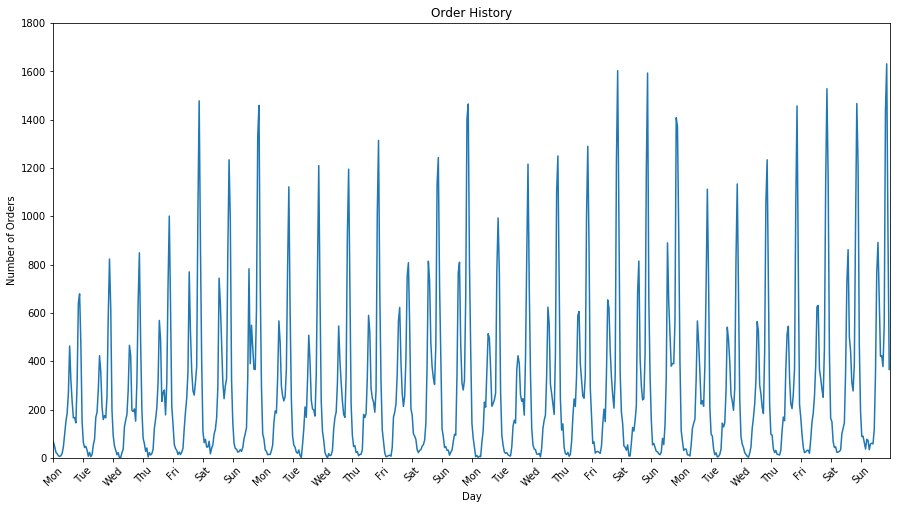

In [9]:
# plot full time series
res = []

for name in xl.sheet_names:
    mylist = map(list, zip(*data[name].values))
    aux = list(it.chain(*mylist))
    del aux[:24]
    res.append(aux)

res = list(it.chain(*res))

print(res)

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#days_repeated = [days for i in range(0, 4)]
days_repeated = days * 4
#days_repeated = list(it.chain(*days))

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(res)
plt.axis([0, 672, 0, 1800])
plt.xticks(range(0,672,24), days_repeated, rotation=45)
plt.xlabel('Day')
plt.ylabel('Number of Orders')
plt.title('Order History')
plt.show()

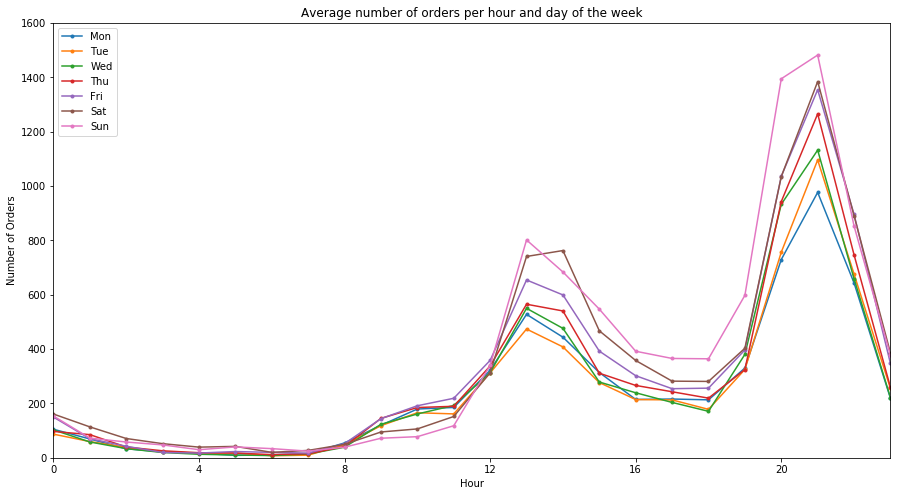

In [10]:
# average orders by hour and day
plt.rcParams['figure.figsize'] = [15, 8]

temp = data['W1'].add(data['W2']).add(data['W3']).add(data['W4'])/4

temp = temp.drop('HOURS', 1)
plt.plot(temp, linestyle='-', marker='.')
plt.axis([0, 23, 0, 1600])
plt.xticks(range(0, 24, 4))
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.title('Average number of orders per hour and day of the week')
plt.legend(days, loc="upper left", fancybox=True)
plt.show()

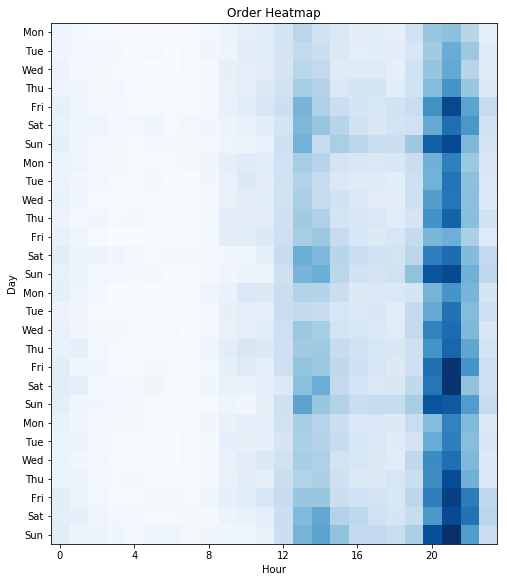

In [7]:
# construct and plot heatmap
plt.rcParams['figure.figsize'] = [8, 15]

orders = [res[i:i + 24] for i in range(0, len(res), 24)]

cols = range(0,24)
rows = range(0,28)
df = pd.DataFrame(orders,
                  columns=cols,
                  index=rows)

ax = plt.imshow(df, interpolation='nearest', cmap='Blues').axes
ax.set_xticks(range(0,24,4))
ax.set_yticks(rows)
ax.set_yticklabels(days_repeated)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Order Heatmap')
ax.grid(False)
plt.show()